In [1]:
# when in notebook
import os
os.chdir('/home/david/Desktop/projects/thesis/')

# when in tmux
# import sys
# sys.path.append('/home/david/Desktop/projects/thesis/')

import numpy as np
import pickle 

from combined_downstream_upstream.utils.LoadModels import *
from combined_downstream_upstream.executors.train_combined_model import trainer
from downstream_classification.dataloader.DataGenerator import DataGenerator
from combined_downstream_upstream.utils.plots import plot_test_signals_12leads_SHL
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# upstream model params
# ---------------
upstream_params = {
    'input_dimension': 12,
    'output_dimension': 12,              
    'hidden_dimmension':  128,           # d_model (int) – the number of expected features in the input (required)???,
    'attention_heads': 8,               # number of attention heads, if None then d_model//64,
    'encoder_number_of_layers': 8,
    'dropout': 0.4,
    'clip': 1,
    'positional_encodings': False,
    'device':'cuda'
}
best_rocauc_and_pr_auc = {
    'seed':[],
    'roc-auc':[],
    'pr-auc':[]
}

seed = 123
np.random.seed(123)
seeds = np.random.randint(0,1000, 50)


/home/david/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


cuda


# Load Models

In [2]:
print('Seed:', seed)
upstream_model   = load_upstream_model(upstream_params, folder_path = './upstream_seq2seq/models/', model_name = 'transformer_cnn_4heads')
downstream_model = load_downstream_model(dropout=0.5,scale=1,num_inputs=12, weights_path='./downstream_classification/models/AF-V9/model_val_rocauc.pt')

config = {
        # general
        'seed':42,
        'metadata_file_path': './downstream_classification/data/combined_data/metadata_only_existant_readings_09042023.csv',
        'data_folder_path': './downstream_classification/data/individual-signals/',
        'targets': ['AF'],
        'leads': ['LI', 'LII', 'LIII', 'aVF', 'aVL', 'aVR','V1','V2','V3','V4','V5','V6'],

        # training
        'batch_size': 128,
        'n_epochs': 10, # catastrophic forgetting
        'weight_decay': 0.3,
        'lr': 0.0005,
        'eval_metric':'rocauc',
        'patience':3,
        'clip':1,
        'loss_function_weight':None,

        # Experiment settings
        'upstream_model':upstream_model,
        'downstream_model':downstream_model,
        'impute_only_missing':False,
        'continue_training_upstream_model':True,
        'model_saving_path':'./combined_downstream_upstream/models/AF-V4-different-seeds',
        }


Seed: 123
Upstream Model File Path: ./upstream_seq2seq/models/transformer_cnn_4heads_1701990699.9536803.pt
Num attention heads: 8


/home/david/anaconda3/lib/python3.9/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


# Load Data

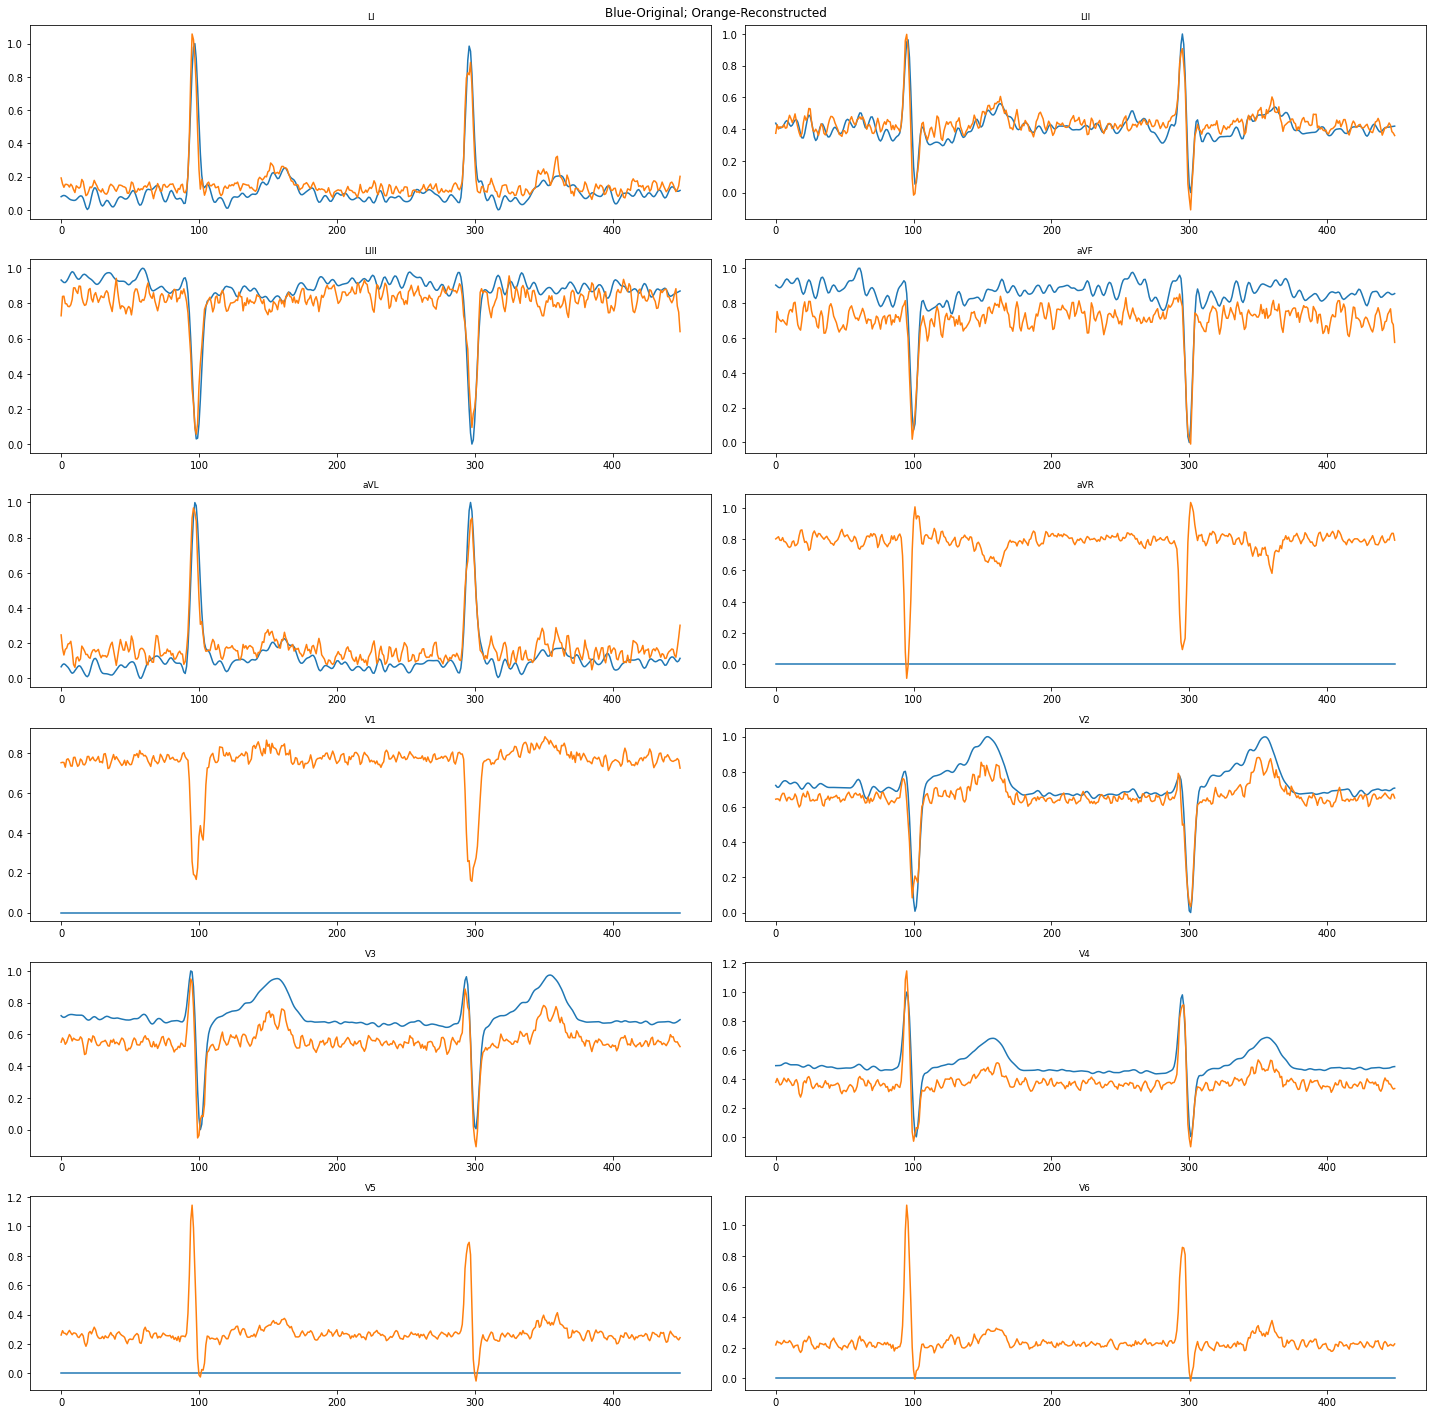

In [3]:

test_generator = DataGenerator(
    metadata_file_path= config['metadata_file_path'],                 # path to metadata file
    data_folder_path = config['data_folder_path'],                    # path to individual signals
    sample='test',                                          # sample we want to create a generator to. Either train, validation or test
    targets=config['targets'],                                        # list of targets we want train on
    batch_size=config['batch_size'],                                  # batch size
    shuffle=True,                                            # Whether to shuffle the list of IDs at the end of each epoch.
    seed = seed
                            )

upstream_model = upstream_model.to(device)

plot_test_signals_12leads_SHL(
    upstream_model, 
    test_generator, 
    device = device, 
    # plot_saving_path=f'{plot_saving_path}/epoch-{epoch}'
)

In [ ]:

model = CombinedModel(upstream_model, downstream_model, device, continue_training_upstream_model=True, impute_only_missing=False)


# Make a Video

In [4]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm
from tqdm import tqdm

# images = [plt.imread(f'/home/david/Desktop/projects/thesis/combined_downstream_upstream/plots/epoch_{j}_signal_num_0_again.png') for j in range(10)]
from PIL import Image
import os
import imageio


def images_to_gif(input_dir, output_gif):
    for f in tqdm(range(17),desc='Processing file'):
        images = []
        for filename in [f'/home/david/Desktop/projects/thesis/combined_downstream_upstream/plots/epoch_{j}_signal_num_{f}_again.png' for j in range(9)]:
            if filename.endswith(".png") or filename.endswith(".jpg"):  # Adjust this based on your image format
                for j in range(7):
                    filepath = os.path.join(input_dir, filename)
                    images.append(imageio.imread(filepath))
            
            imageio.mimsave(f'{output_gif}/signal_num_{f}.gif', images, duration=0.2)  # Adjust the duration as needed


# def images_to_gif(input_dir, output_gif):
#     images = []
#     for filename in sorted(os.listdir(input_dir)):
#         if filename.endswith(".png") or filename.endswith(".jpg"):  # Adjust this based on your image format
#             filepath = os.path.join(input_dir, filename)
#             images.append(imageio.imread(filepath))
    
#     imageio.mimsave(output_gif, images, duration=0.2)  # Adjust the duration as needed

if __name__ == "__main__":
    input_dir = "path/to/your/input/directory"
    output_gif = "/home/david/Desktop/projects/thesis/combined_downstream_upstream/gifs/"

    images_to_gif(input_dir, output_gif)


Processing file: 100%|██████████| 17/17 [11:13<00:00, 39.64s/it]


In [6]:
os.getcwd()

'/home/david/Desktop/projects/thesis/combined_downstream_upstream/notebooks'